# The beauty of computational efficiency and the FFT

When we discuss "computational efficiency", you often hear people throw around phrases like $O(n^2)$ or $O(nlogn)$. We talk about them in the abstract, and it can be hard to appreciate what these distinctions mean and how important they are. So let's take a quick look at what computational efficiency looks like in the context of a very famous algorithm: The Fourier Transform.

## A short primer on the Fourier Transform
Briefly, A Fourier Transform is used for uncovering the spectral information that is present in a signal. AKA, it tells us about oscillatory components in the signal, and has [a wide range](http://dsp.stackexchange.com/questions/69/why-is-the-fourier-transform-so-important) of uses in communications, signal processing, and even neuroscience analysis.

Here's a [Quora post](https://www.quora.com/What-is-an-intuitive-way-of-explaining-how-the-Fourier-transform-works) that discusses Fourier Transforms more generally. The first explanation is fantastic and full of history and detail.

The challenge with the Fourier Transform is that it can take a really long time to compute. If you h ave a signal of length $n$, then you're calculating $n$ Fourier components for each point in the (length $n$) signal. This means that the number of operations required to calculate a fourier transform is $n * n$ or $O(n^2)$.

For a quick intuition into what a difference this makes. Consider two signals, one of length 10, and the other of length 100. Since the Fourier Transform is $O(n^2)$, the length 100 signal will take *2 orders of magnitude* longer to compute, even though it is only *1 order of magnitude longer in length*.

Think this isn't a big deal? Let's see what happens when the signal gets longer. First off, a very short signal:

In [ ]:
# We can use the `time` and the `numpy` module to time how long it takes to do an FFT
from time import time
import numpy as np
import seaborn as sns
sns.set_style('white')

# For a signal of length ~1000. Say, 100ms of a 10KHz audio sample.
signal = np.random.randn(1009)
start = time()
_ = np.fft.fft(signal)
stop = time()
print('It takes {} seconds to do the FFT'.format(stop-start))

That's not too bad - ~.003 seconds is pretty fast. But here's where the $O(n^2)$ thing really gets us...

In [ ]:
# We'll test out how long the FFT takes for a few lengths
test_primes = [11, 101, 1009, 10009, 100019]

In [ ]:
# Let's try a few slightly longer signals
for i_length in test_primes:
    # Calculate the number of factors for this length (we'll see why later)
    factors = [ii for ii in range(1, 1000) if i_length % ii == 0]
    # Generate a random signal w/ this length
    signal = np.random.randn(i_length)
    # Now time the FFT
    start = time()
    _ = np.fft.fft(signal)
    stop = time()
    print('With data of length {} ({} factors), it takes {} seconds to do the FFT'.format(
            i_length, len(factors), stop-start))

Whoah wait a sec, that last one took way longer than everything else. We increased the length of the data by a factor of 10, but the time it took went up by a factor of 100. Not good. That means that if we want to perform an FFT on a signal that was 10 times longer, it'd take us about 42 minutes. 100 times longer? That'd take *~3 days.*

Given how important the Fourier Transform is, it'd be great if we could speed it up somehow. 

> *You'll notice that I chose a very particular set of numbers above. Specifically, I chose numbers that were primes (or nearly primes) meaning that they couldn't be broken down into products of smaller numbers. That turns out to be really important in allowing the FFT to do its magic. When your signal length is a prime number, then you don't gain any speedup from the FFT, as I'll show below.*

## Enter the Fast Fourier Transform
The Fast Fourier Transform (FFT) is one of the most important algorithms to come out of the last century because it drastically speeds up the performance of the Fourier Transform. It accomplishes this by breaking down all those $n^2$ computations into a smaller number of computations, and then putting them together at the end to get the same result. This is called **factorizing**.

You can think of factorizing like trying to move a bunch of groceries from your car to your fridge. Say you have 20 items in your car. One way to do this is to individually take each item, pull it from the car, walk to the house, place it in the fridge. It'd take you 20 trips to do this. Factorizing is like putting your 20 items into 2 grocery bags. Now you only need to make 2 trips to the house - one for each grocery bag. The first approach requires 20 trips to the house, and the second requires 2 trips. You've just reduced the number of trips by an order of magnitude!

The FFT accomplishes its factorization by recognizing that signals of a certain length can be broken down (factorized) into smaller signals. How many smaller signals? Well, that depends on the length of the original signal. If a number has many *factors*, it means that it can be broken down into a product of many different, smaller, signals.

In practice, this means that if the input to an FFT has a lot of factors, then you gain a bigger speedup from the FFT algorithm. On one end, a signal with a length == a power of two will have a ton of factors, and yield the greatest speedups. A signal with length == a prime number will be the slowest because it has no factors. Below is a quick simulation to see how much of a difference this makes.

> Here are some useful links explaining Fourier Transforms, as well as the FFT:
> * [A Quora post](https://www.quora.com/What-is-an-intuitive-explanation-of-the-FFT-algorithm) with some great answers on the intuition behind the Fast Fourier Transform.
> * [The wikipedia entry](https://en.wikipedia.org/wiki/Fast_Fourier_transform) for FFTs also has some nice links.
> * [A post on the FFT](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/) from Jake Vanderplas is also a great explanation of how it works.

In [ ]:
import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
%matplotlib inline

## The beautiful efficiency of the FFT
To see what the FFT's efficiency looks like, we'll simulate data of different lengths and see how long it takes to compute the FFT at each length. We'll create a random vector of gaussian noise ranging from length 1 to 10,000. For each vector, we'll compute the FFT, and time how long it took to compute. I've already taken the liberty of doing this (repeated 3 times, and then averaged together). Those times are stored in fft_times.csv.

In [ ]:
# Let's read in the data and see how it looks
df = pd.read_csv('../data/fft_times.csv', index_col=0)
df = df.apply(pd.to_numeric)
df = df.mean(0).to_frame('time')
df.index = df.index.astype(int)
df['length'] = df.index.values

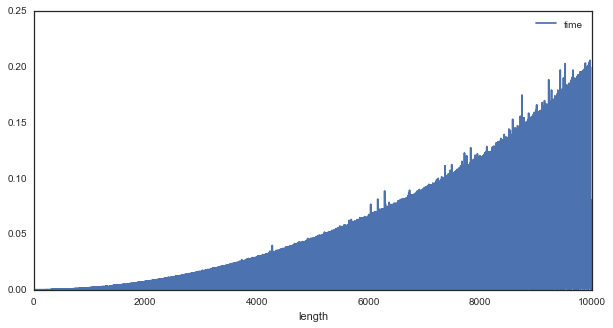

In [ ]:
# First off, it's clear that computation time grows nonlinearly with signal length
df.plot('length', 'time', figsize=(10, 5))

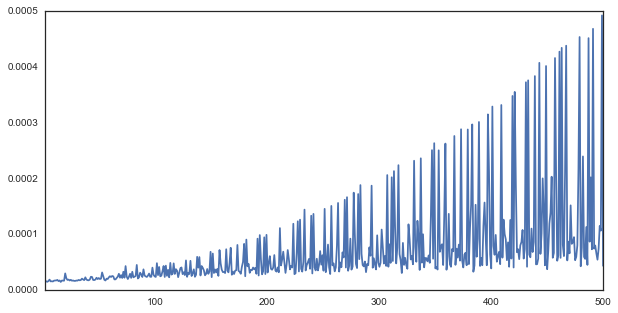

In [ ]:
# However, upon closer inspection, it's clear that there's much variability
winsize = 500
i = 0
j = i + winsize
df.iloc[i:j]['time'].plot(figsize=(10, 5))

As you can see, there appear to be multiple trends in the data. There seems to be a "most inefficient" line of growth in the data, as well as a "more efficient" and a "most efficient" trend. These correspond to lengths that are particularly good for an FFT.

We can use regression to find the "linear" relationship between length of signal and time of FFT. However, if there are any trends in the data that are **nonlinear**, then they should show up as errors in the regression model. Let's see if that happens...

In [ ]:
# We'll use a regression model to try and fit how length predicts time
mod = linear_model.LinearRegression()
xfit = df['length']
xfit = np.vstack([xfit, xfit**2, xfit**3, xfit**4]).T
yfit = df['time'].reshape([-1, 1])

In [ ]:
# Now fit to our data, and calculate the error for each datapoint
mod.fit(xfit, yfit)
df['ypred'] = mod.predict(xfit)
df['diff'] = df['time'] - df.ypred

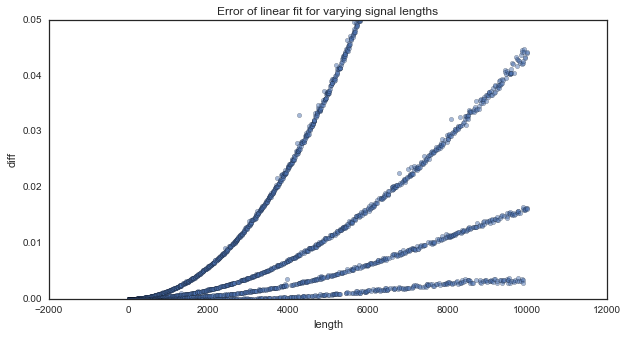

In [ ]:
# As the length grows, the trends in the data begin to diverge more and more
ax = df.plot('length', 'diff', kind='scatter',
             style='.', alpha=.5, figsize=(10, 5))
ax.set_ylim([0, .05])
ax.set_title('Error of linear fit for varying signal lengths')

It looks like there are some clear components of the data that *don't* follow a linear relationship. Moreover, this seems to be systematic. We clearly see several separate traces in the error plot, which means that there are patterns in the data that follow different non-linear trends.

But we already know that the FFT efficiency will differ depending on the number of factors of the signal's length. Let's see if that's related to the plot above...

In [ ]:
# We'll write a helper function that shows how many (<100) factors each length has
find_n_factors = lambda n: len([i for i in range(1, min(100, n-1)) if n % i == 0])

# This tells us the number of factors for all lengths we tried
df['n_factors'] = df['length'].map(find_n_factors)

# We now have a column that tells us how many factors each iteration had
df.tail()

,time,length,ypred,diff,n_factors
9995,0.031189,9995,0.035864,-0.004675,2
9996,0.000974,9996,0.035873,-0.034899,18
9997,0.012076,9997,0.035881,-0.023805,2
9998,0.080163,9998,0.035889,0.044274,2
9999,0.002135,9999,0.035897,-0.033763,6


Finally, we can plot time to compue the FFT as a function of the number of factors for that signal length.

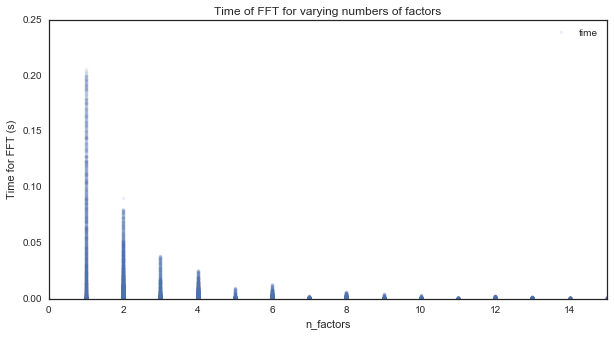

In [ ]:
# As we can see, the FFT time drops quickly as a function of the number of factors
ax = df.plot('n_factors', 'time', style=['.'], figsize=(10, 5), alpha=.1)
ax.set_xlim([0, 15])
ax.set_ylabel('Time for FFT (s)')
ax.set_title('Time of FFT for varying numbers of factors')

The fewer factors in the length of the signal, the longer the FFT takes.

Finally, we can show how the length of computation time changes for each group of factors. We'll plot the signal length along with the time to compute the FFT, this time colored by the number of factors for each point.

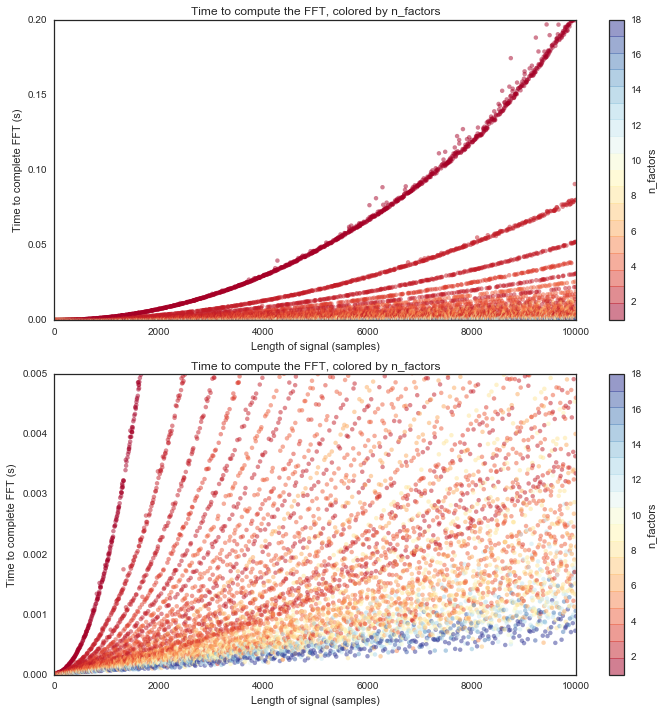

In [ ]:
# We'll plot two zoom levels to see the detail
f, axs = plt.subplots(2, 1, figsize=(10, 5))
vmin, vmax = 1, 18
for ax in axs:
    ax = df.plot.scatter('length', 'time', c='n_factors', lw=0, cmap=plt.cm.get_cmap('RdYlBu', vmax),
                                           figsize=(10, 10), vmin=vmin, vmax=vmax, ax=ax, alpha=.5)
    ax.set_xlabel('Length of signal (samples)')
    ax.set_ylabel('Time to complete FFT (s)')
    ax.set_title('Time to compute the FFT, colored by n_factors')
_ = plt.setp(axs, xlim=[0, df['length'].max()])
_ = plt.setp(axs[0], ylim=[0, .2])
_ = plt.setp(axs[1], ylim=[0, .005])
plt.tight_layout()

Each of those colored traces spreading upwards represents a particular strategy that the FFT uses for that number of factors. As you can see, the FFT will take a lot longer (and scales exponentially) with fewer factors (see the red lines). It takes much less time (and scales more linearly) with more factors (see the blue lines).

And that right there is the beauty of methods like the FFT. They leverage the structure of mathematics to take a computation that goes on for days, and figure out how to do it in seconds.